
Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best AUC for Random Forest: 0.9667
Classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        81
           1       0.92      0.90      0.91        80

    accuracy                           0.91       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.91      0.91      0.91       161


Tuning Gradient Boosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best AUC for Gradient Boosting: 0.9660
Classification report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        81
           1       0.91      0.91      0.91        80

    accuracy                           0.91       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.91      0.91      0.91       161


Tuning

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best AUC for XGBoost: 0.9685
Classification report for XGBoost:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        81
           1       0.90      0.89      0.89        80

    accuracy                           0.89       161
   macro avg       0.89      0.89      0.89       161
weighted avg       0.89      0.89      0.89       161


Tuning AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best AUC for AdaBoost: 0.8744
Classification report for AdaBoost:

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        81
           1       0.84      0.72      0.78        80

    accuracy                           0.80       161
   macro avg       0.80      0.79      0.79       161
weighted avg       0.80      0.80      0.79       161



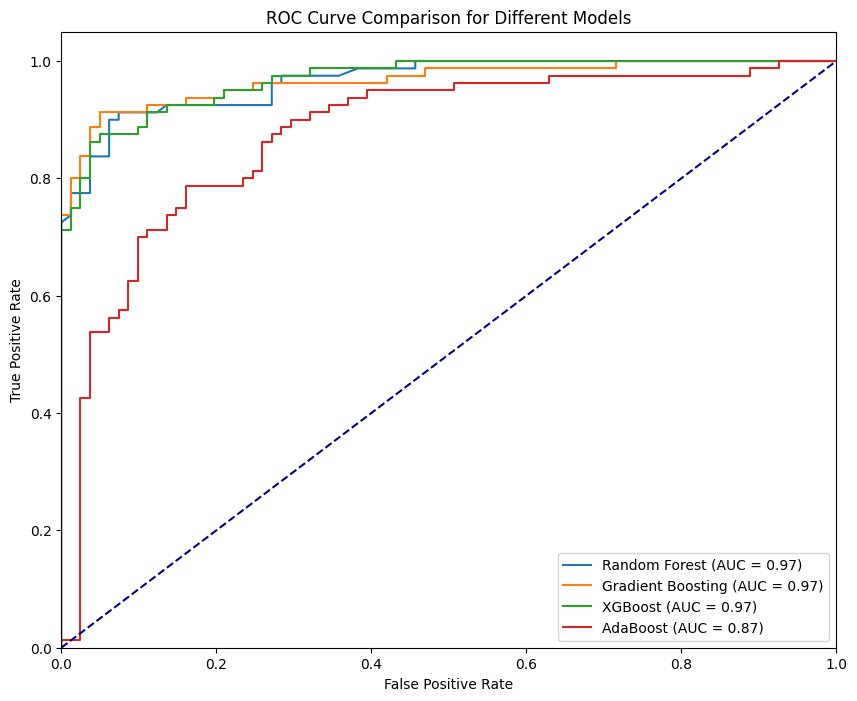


Best Model: XGBoost with AUC = 0.9685


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load dataset
file_path = 'MLprostateAverageV2.csv'  # replace with your actual file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning (Impute Missing Values)

from sklearn.impute import SimpleImputer

numerical_cols = ['Age', 'IMC', 'APS_preop', 'Volume']  # Replace with actual numerical columns
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

categorical_cols = ['MCAS', 'DM', 'TR', 'ASA']  # Replace with actual categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Step 3: Encoding Categorical Variables (One-Hot Encoding or Ordinal Encoding)

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 4: Define features (X) and target (y)
X = df.drop(columns=['1yearBCR'])  # Replace '1yearBCR' with your actual target column
y = df['1yearBCR']

# Step 5: Handle Class Imbalance with SMOTE (Optional, only if the target is imbalanced)
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Step 6: Feature Scaling (Standardization)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 7: Split the dataset into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 8: Model Training and Hyperparameter Tuning

# Define the classifiers to use
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Define the hyperparameter grids for tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.05],
        'max_depth': [3, 4, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

# Step 9: Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 10: Train, tune, and evaluate each model
# Initialize variables to store the best model and score
best_auc = 0
best_classifier_name = None
best_model = None

# Plot for ROC curves
plt.figure(figsize=(10, 8))

# Loop through the classifiers and perform grid search
for name, clf in classifiers.items():
    print(f"\nTuning {name}...")

    # Perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = grid_search.best_estimator_
    
    # Make probability predictions
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"Best AUC for {name}: {auc_score:.4f}")
    
    # Keep track of the best model based on AUC score
    if auc_score > best_auc:
        best_auc = auc_score
        best_classifier_name = name
    
    # Generate classification report
    y_pred = best_model.predict(X_test)
    print(f"Classification report for {name}:\n")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

# Step 11: Plot ROC Curves for all models
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Different Models')
plt.legend(loc='lower right')
plt.show()

# Print the best model summary
print(f"\nBest Model: {best_classifier_name} with AUC = {best_auc:.4f}")
